In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.returns import MarketReturns
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import Hold,PeriodicRebalance

plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download data using ee103 code (to be integrated) 

In [3]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

## Market simulator 

In [4]:
a = pd.DataFrame(data=5e-4, index=returns.index, columns=returns.columns)
b = pd.DataFrame(data=1, index=returns.index, columns=returns.columns)
s = pd.DataFrame(data=0, index=returns.index, columns=returns.columns)

simulated_tcost = TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
market_returns = MarketReturns(returns)

simulator = MarketSimulator(market_returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

## Portfolio

In [5]:
small_fund = 1E8
big_fund = 1E10

p = pd.Series(index=returns.columns, data=1)/len(returns.columns)
weights=p/sum(p)

p_small = small_fund*p
p_large = big_fund*p

## Policy

In [6]:
def select_starts_periods(period_property, timestamps):
    selected = [timestamps[0]]
    last_day = timestamps[0]
    for day in timestamps[1:]:
        if not (period_property(day) == period_property(last_day)):
            selected.append(day)
            last_day=day
    return selected

In [11]:
selectors=pd.Series(index=['D','W','M','Q','Y'],
                    data=[lambda t: t.day,lambda t: t.week,lambda t: t.month,lambda t: t.quarter,lambda t: t.year])
rebalancing_times = selectors.apply(lambda x: select_starts_periods(x, returns.index) )
policies = rebalancing_times.apply(lambda x: PeriodicRebalance(target=weights, rebalancing_times=x))
policies['H'] = Hold()

## Simulations

In [8]:
res_small_fund=policies.apply(lambda x: simulator.run_backtest(p_small, returns.index, policy=x))

In [198]:
res_large_fund=policies.apply(lambda x: simulator.run_backtest(p_large, returns.index, policy=x))

In [222]:
res=pd.DataFrame({'$100M':res_small_fund, '$10B': res_large_fund})

## Results 

In [223]:
pandl = lambda res: 100*(res.v[-1]-res.initial_val)/res.initial_val
tcosts = lambda res: 100*res._data['simulation.TcostModel'].sum().sum()/res.initial_val
tmp=pd.Panel({'P&L':res.applymap(pandl), 'TCosts':res.applymap(tcosts)})
result_df = tmp.swapaxes(0,1).swapaxes(1,2).to_frame().T
result_df

major      $100M                 $10B          
minor        P&L    TCosts        P&L    TCosts
D      23.830190  1.734194  16.075800  7.403673
W      20.542337  0.890337  15.598722  4.550467
M      17.092398  0.452507  14.464748  2.519010
Q      18.700196  0.339621  16.226101  2.223273
Y      19.679057  0.194750  18.129632  1.359515
H      14.117630  0.000000  14.117630  0.000000

In [224]:
print(result_df.to_latex(float_format='%.2f%%'))

\begin{tabular}{lrrrr}
\toprule
major &  \$100M &        &   \$10B &        \\
minor &    P\&L & TCosts &    P\&L & TCosts \\
\midrule
D & 23.83\% &  1.73\% & 16.08\% &  7.40\% \\
W & 20.54\% &  0.89\% & 15.60\% &  4.55\% \\
M & 17.09\% &  0.45\% & 14.46\% &  2.52\% \\
Q & 18.70\% &  0.34\% & 16.23\% &  2.22\% \\
Y & 19.68\% &  0.19\% & 18.13\% &  1.36\% \\
H & 14.12\% &  0.00\% & 14.12\% &  0.00\% \\
\bottomrule
\end{tabular}



# Plots 

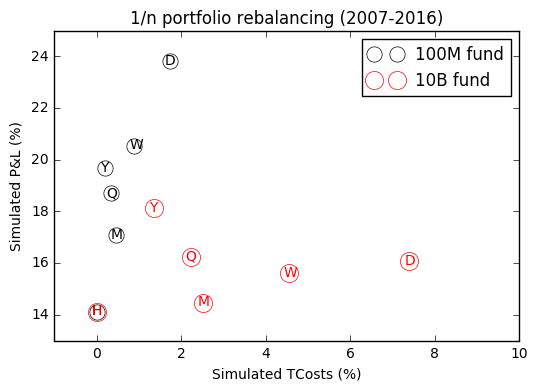

In [245]:
offsetx = .12
offsety = .13

for ticker, values in result_df.iterrows():
    for size, coord in values.unstack().iterrows():
        x,y=coord['TCosts'],coord['P&L']
        if size=='$100M':
            line1,=plt.plot(x,y, 'ko', markersize=11, fillstyle='none', label='100M fund')
            plt.text(x-offsetx,y-offsety, ticker)

        if size=='$10B':
            line2,=plt.plot(x,y, 'ro', markersize=13, fillstyle='none', label='10B fund')
            plt.text(x-offsetx,y-offsety,ticker,color='r' )

plt.xlim([-1, 10])
plt.ylim([13, 25])
plt.legend(loc='upper right',handles=[line1, line2])
plt.xlabel("Simulated TCosts (%)")
plt.ylabel("Simulated P&L (%)")
plt.title("1/n portfolio rebalancing (2007-2016)")

plt.savefig(plotdir+'pandl_vs_tcost.png')

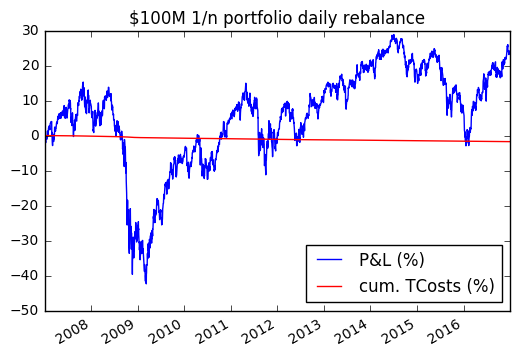

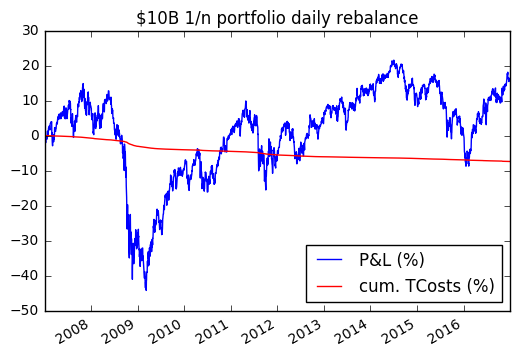

In [270]:
for k,results in res.loc['D'].iteritems():
    plt.figure()
    (100*(results.v-results.initial_val)/results.initial_val).plot(label='P&L (%)')
    (100*(-results._data['simulation.TcostModel'].sum(1).cumsum())/results.initial_val).plot(style='r',label='cum. TCosts (%)')
    plt.legend(loc='lower right')
    plt.title('%s 1/n portfolio daily rebalance'%k)
    plt.savefig(plotdir+'%s_pandl_tcost_tseries.png'%k[1:])